# VC Portfolio Simulator

This document is intended to help those interested in venture capital think about the asset class and potential for returns. Unless specified, all results are net to LPs, so carry of 20% is already discounted where appropriate.

As an exercise, I built a simulation that attempts to recreate historical performance tracked by Cambridge Associates. I took data from [this 2020 report](https://www.cambridgeassociates.com/wp-content/uploads/2020/07/WEB-2020-Q1-USVC-Benchmark-Book.pdf) (page 14), and filtered it for the 10 year period between 2004 and 2013. I chose that period because the vintages surrouding the internet bubble show extraordinary volatility, and discarded years closer to 2020 given that it takes about 7-8 years for the TVPI to stabilize.

## Cambridge Associates Data

In [3]:
import tabulate

data = [
        [2004,1.69,1.72,1.20,1.82,0.82,63],
        [2005,1.68,1.66,1.41,2.07,0.91,61],
        [2006,1.69,1.56,1.59,1.95,0.75,78],
        [2007,2.29,2.38,1.76,2.93,1.31,68],
        [2008,1.77,1.71,1.40,2.21,1.09,64],
        [2009,2.10,2.12,1.75,2.46,1.30,23],
        [2010,3.21,2.80,2.12,3.41,1.41,48],
        [2011,2.48,2.26,1.90,2.71,1.39,44],
        [2012,2.21,2.48,1.73,2.37,1.35,55],
        [2013,2.02,2.01,1.81,2.26,1.34,59],
        ['Average',2.11, 2.07, 1.67, 2.42, 1.17, 56]
]

headers = ['Vintage','Pooled','Mean','Median','Upper Q','Lower Q','Funds']
table = tabulate.tabulate(data, headers=headers)
print(table)



Vintage      Pooled    Mean    Median    Upper Q    Lower Q    Funds
---------  --------  ------  --------  ---------  ---------  -------
2004           1.69    1.72      1.2        1.82       0.82       63
2005           1.68    1.66      1.41       2.07       0.91       61
2006           1.69    1.56      1.59       1.95       0.75       78
2007           2.29    2.38      1.76       2.93       1.31       68
2008           1.77    1.71      1.4        2.21       1.09       64
2009           2.1     2.12      1.75       2.46       1.3        23
2010           3.21    2.8       2.12       3.41       1.41       48
2011           2.48    2.26      1.9        2.71       1.39       44
2012           2.21    2.48      1.73       2.37       1.35       55
2013           2.02    2.01      1.81       2.26       1.34       59
Average        2.11    2.07      1.67       2.42       1.17       56


## Simulation Rationale

The goal for our simulation is to output a distribution that matches the average row in the table above. There are two sets of parameters I will be adjusting in order to adjust the distribution. First, I will divide the set of possible outcomes into "failed", "breakeven", "singles", "homerun", and "unicorn", and assign each a probability. Then, I will adjust the range of expected proceeds for each category.

After I feel good with the results, I will do a sanity check against other sources, such as [500 startups](https://500hats.com/99-vc-problems-but-a-batch-ain-t-one-why-portfolio-size-matters-for-returns-16cf556d4af0) and [Angel List](https://venture.angellist.com/v/venture/calculator)

There are a few other important parameters:
- **Number of Investments**: 24. As of right now, our first fund has 21 investments. Our next fund will be larger, and it seems possible to support 2 investments per partner per year. With 4 partners investing actively over 3 years, we get 24 investments.
- **Number of Funds**: 4000. According to crunchbase, there are about 4000 active investors with more than 20 investments. This is important to get a sense of what the tails look like.
- **Fund size, fees, duration, follow-on capital**: standard values based on our current fund. Note that follow-on capital is never deployed using this simple model. 


## Simulation

In [4]:
# 1. Import necessary libraries

import numpy as np
import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 2. Define the investment parameters

fund_size = 50e6
fees = 0.12
carry = 0.2
duration_years = 7
investable_capital = fund_size * (1 - fees)
follow_on_percent = 0.20
primary_investments = investable_capital * (1 - follow_on_percent)
check_size = primary_investments / 24
number_vcs = 4_000 # approximate number of VCs with more than 20 investments in the USA, according to crunchbase

# 3. Define the probabilities and returns for each outcome

# "failed", "breakeven", "singles", "homerun", and "unicorn"
probabilities = [0.59, 0.15, 0.15, 0.10, 0.01]

# 4. Simulate the returns for the 24 companies 100 times

np.random.seed(42)
total_returns = []

def get_net(x, carry=carry, fund_size=fund_size):
    """ returns x minus carry when appropriate """
    return (max(x-fund_size,0)*(1-carry)+min(x, fund_size))

for _ in range(number_vcs):
    outcomes = np.random.choice([0, np.random.uniform(1,1.25), np.random.uniform(3,8), np.random.uniform(6, 20), np.random.uniform(50, 175)], 
                                size=24, p=probabilities, replace=True)
    investments_returned = outcomes * check_size
    total_return = get_net(investments_returned.sum())
    total_returns.append(total_return)


## Results

In [5]:
# 5. Calculate quartiles for the 100 simulations

def get_percentile(sorted_returns, percentile):
    """ returns percentile from an ordered list """
    return sorted_returns[int(len(sorted_returns)*percentile)]

def get_irr(tvpi, years=duration_years):
    """ returns percentile from an ordered list """
    return (tvpi**(1/years)-1)*100

sorted_returns = sorted(total_returns)

net_quartiles = {f"{pcnt*100:,.0f}th": get_percentile(sorted_returns,pcnt) for pcnt in [0.25,0.50,0.75,0.90,0.95,0.99]}
net_quartiles['Mean'] = sum(sorted_returns)/len(sorted_returns)
net_quartiles['Top'] = sorted_returns[-1]

# 6. Display the results

data = []
headers = ['Percentile', 'Net Proceeds', 'Net TVPI', f'IRR ({duration_years} yrs)']
for q, val in net_quartiles.items():
    tvpi = val/fund_size
    irr = get_irr(tvpi)
    data.append([q, f"${val / 1_000_000:.0f} M", f"{tvpi:,.2f} x", f"{irr:.2f} %"])

# .INX	01/01/2004 $1,131.13	12/31/2013 $1,848.36
data.append(["S&P500", "N/A", "1.63 x", f"{get_irr(1.63):,.2f} %"])

table = tabulate.tabulate(data, headers=headers)
print(table)


Percentile    Net Proceeds    Net TVPI    IRR (7 yrs)
------------  --------------  ----------  -------------
25th          $59 M           1.18 x      2.39 %
50th          $80 M           1.61 x      7.03 %
75th          $122 M          2.43 x      13.53 %
90th          $215 M          4.31 x      23.20 %
95th          $253 M          5.07 x      26.09 %
99th          $366 M          7.32 x      32.89 %
Mean          $104 M          2.09 x      11.08 %
Top           $645 M          12.91 x     44.11 %
S&P500        N/A             1.63 x      7.23 %


## Visualization

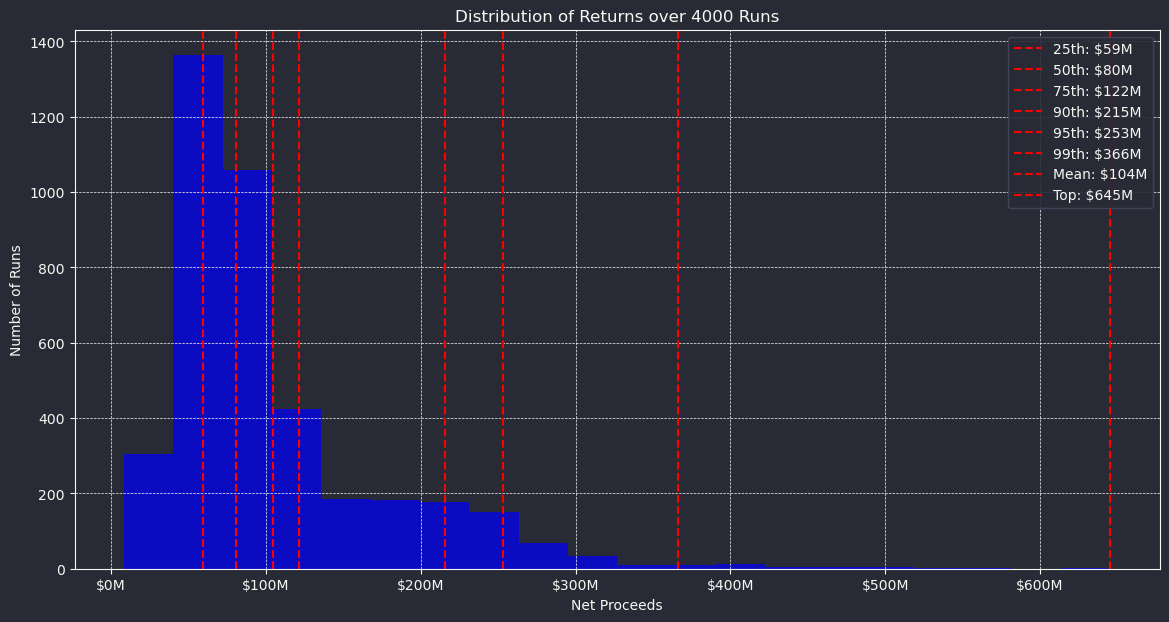

In [6]:
# 7. Visualize the results

plt.figure(figsize=(14, 7))
plt.hist(total_returns, bins=20, color='blue', alpha=0.7)
for q, val in net_quartiles.items():
    plt.axvline(val, color='red', linestyle='dashed', label=f"{q}: ${val/1e6:,.0f}M")
plt.title(f"Distribution of Returns over {number_vcs} Runs")
plt.xlabel("Net Proceeds")
plt.ylabel("Number of Runs")
plt.legend()

# Custom formatter for x-axis
formatter = ticker.FuncFormatter(lambda x, pos: f"${x/1e6:,.0f}M")
plt.gca().xaxis.set_major_formatter(formatter)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

## Conclusion

The simulation shows a distribution consistent with the initial Cambridge Associates data, and also consistent with anecdotal data reported by experienced venture capitalists. For this particular period, the median fund (50th percentile) would have performed simmilarly to the S&P 500 index, whereas a fund at the top quartile would have almost doubled the IRR of the index. Because of the exponential nature of startup returns, funds at the 90th and 95th percentile perform extraordinarily well. Of course, these are different asset classes, with varying characteristics of risk, liquidity, and tax exposure (bless the [QSBS](https://www.investopedia.com/terms/q/qsbs-qualified-small-business-stock.asp)).

If you have any feedback or suggestions, please reach out.